# Text Embeddings Workshop: From Word2Vec to Modern Applications

## Learning Objectives
By the end of this notebook, you will:
- Understand how word embeddings capture semantic meaning in vector space
- Implement the classic "king - man + woman = queen" analogy
- Visualize word relationships in high-dimensional space
- Apply embeddings to library metadata challenges
- Understand tokenization fundamentals

## Why Word Embeddings Matter for Library Science

Imagine you're a librarian trying to distinguish between two people named "Franz Schubert":
- **Franz Schubert (1797-1828)**: Austrian composer, wrote symphonies and lieder
- **Franz August Schubert (1805-1893)**: German artist, created archaeological illustrations

Traditional string matching would see these as nearly identical. But word embeddings can understand that "symphony" and "archaeological" represent fundamentally different semantic domains.

Let's explore how this works!

## Part 1: Setting Up Our Embedding Environment

First, we need to install the required libraries. The `staticvectors` library provides an efficient way to work with pre-trained embeddings.

In [30]:
# Install required packages
!pip install staticvectors numpy matplotlib seaborn pandas scikit-learn

# Import libraries we'll use throughout this notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from staticvectors import StaticVectors
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Environment setup complete!")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
✅ Environment setup complete!


## Part 2: Loading Pre-trained Word2Vec Embeddings

We'll use Google's pre-trained Word2Vec model, which was trained on billions of words from Google News. This model learned to represent words as 300-dimensional vectors by predicting surrounding words in context.

Think of each word as a point in a 300-dimensional space where similar words cluster together.

In [31]:
# Load the pre-trained Word2Vec model
# This model contains vectors for ~3 million words and phrases
print("Loading Word2Vec model... (this may take a minute)")
model = StaticVectors("neuml/word2vec")
print("✅ Model loaded successfully!")

# Let's examine what we have
print(f"\nModel information:")
print(f"- Vector dimensions: {model.shape[1] if hasattr(model, 'shape') else '300 (standard Word2Vec)'}")

# Test with a simple word
test_embedding = model.embeddings(["king"])
print(f"- Embedding shape for 'king': {test_embedding.shape}")
print(f"- First 10 dimensions of 'king': {test_embedding[0][:10]}")

Loading Word2Vec model... (this may take a minute)
✅ Model loaded successfully!

Model information:
- Vector dimensions: 300 (standard Word2Vec)
- Embedding shape for 'king': (1, 300)
- First 10 dimensions of 'king': [ 0.04340638  0.01026275  0.00296526  0.04811715 -0.00883269 -0.01244989
  0.03852737 -0.06830617  0.01766539  0.1251719 ]


## Part 3: Understanding Vector Operations

The magic of word embeddings lies in how vector arithmetic captures semantic relationships. When we do math with word vectors, we're actually doing math with meaning!

Let's start by examining some basic relationships.

In [37]:
# Predefined vocabulary sets for different types of analogies
VOCABULARY_SETS = {
    "royal_gender": [
        "queen", "woman", "princess", "monarch", "royal", "crown", "throne",
        "emperor", "duchess", "lady", "female", "male", "boy", "girl",
        "prince", "king", "man", "person", "ruler", "noble", "empress"
    ],
    
    "geography": [
        "Paris", "France", "London", "England", "Berlin", "Germany", "Rome", "Italy",
        "Madrid", "Spain", "Tokyo", "Japan", "Beijing", "China", "Moscow", "Russia",
        "capital", "country", "nation", "city", "Europe", "Asia", "America"
    ],
    
    "family_relationships": [
        "father", "mother", "son", "daughter", "brother", "sister", "uncle", "aunt",
        "grandfather", "grandmother", "nephew", "niece", "cousin", "parent", "child",
        "husband", "wife", "family", "relative", "male", "female", "man", "woman"
    ],
    
    "academic_professional": [
        "teacher", "student", "professor", "pupil", "doctor", "patient", "lawyer", "client",
        "chef", "cook", "author", "reader", "actor", "audience", "musician", "listener",
        "scientist", "researcher", "engineer", "designer", "leader", "follower"
    ],
    
    "animals": [
        "lion", "lioness", "tiger", "tigress", "dog", "bitch", "cat", "queen", 
        "bull", "cow", "stallion", "mare", "rooster", "hen", "ram", "ewe",
        "male", "female", "animal", "mammal", "wild", "domestic", "young", "adult"
    ],
    
    "music": [
        "composer", "conductor", "performer", "musician", "pianist", "violinist", "singer",
        "symphony", "sonata", "concerto", "quartet", "opera", "oratorio", "lieder",
        "piano", "violin", "cello", "flute", "trumpet", "orchestra", "ensemble", "choir",
        "classical", "romantic", "baroque", "modern", "jazz", "folk", "popular",
        "melody", "harmony", "rhythm", "tempo", "pitch", "scale", "chord", "key",
        "composition", "arrangement", "improvisation", "performance", "recording", "score",
        "Mozart", "Beethoven", "Bach", "Schubert", "Chopin", "Wagner", "Brahms", "Haydn"
    ],
    
    "academic_subjects": [
        "mathematics", "algebra", "science", "physics", "literature", "poetry",
        "history", "archaeology", "music", "symphony", "art", "painting",
        "philosophy", "logic", "chemistry", "biology", "psychology", "sociology"
    ]
}

def find_similar_words(model, target_vector, vocabulary_set="music", 
                      custom_words=None, exclude_words=None, top_k=5):
    """
    Find words most similar to a target vector from a specified vocabulary set.
    
    This function demonstrates how vector similarity works by testing against
    a curated set of words. In production systems, you'd search the entire
    vocabulary using more efficient algorithms.
    
    Args:
        model: The word embedding model
        target_vector: The vector to find similarities for
        vocabulary_set: Name of predefined vocabulary set to use
        custom_words: Optional list of custom words to search instead
        exclude_words: Words to exclude from results
        top_k: Number of top results to return
    
    Returns:
        List of (word, similarity_score) tuples, sorted by similarity
    """
    if exclude_words is None:
        exclude_words = []
    
    # Choose which words to search
    if custom_words is not None:
        search_words = custom_words
        print(f"🔍 Searching custom vocabulary: {len(search_words)} words")
    elif vocabulary_set in VOCABULARY_SETS:
        search_words = VOCABULARY_SETS[vocabulary_set]
        print(f"🔍 Searching '{vocabulary_set}' vocabulary: {len(search_words)} words")
    else:
        available_sets = list(VOCABULARY_SETS.keys())
        print(f"❌ Unknown vocabulary set '{vocabulary_set}'")
        print(f"📋 Available sets: {', '.join(available_sets)}")
        return []
    
    similarities = []
    valid_words = []
    not_found_words = []
    
    for word in search_words:
        if word.lower() not in [w.lower() for w in exclude_words]:
            try:
                word_vector = model.embeddings([word])
                similarity = cosine_similarity(target_vector.reshape(1, -1), 
                                             word_vector.reshape(1, -1))[0][0]
                similarities.append(similarity)
                valid_words.append(word)
            except:
                # Track words not found in model vocabulary
                not_found_words.append(word)
                continue
    
    # Report vocabulary coverage
    total_searched = len(search_words) - len([w for w in search_words if w.lower() in [e.lower() for e in exclude_words]])
    coverage = len(valid_words) / total_searched if total_searched > 0 else 0
    print(f"📊 Vocabulary coverage: {len(valid_words)}/{total_searched} words ({coverage:.1%})")
    
    if not_found_words and len(not_found_words) <= 5:
        print(f"⚠️  Words not in model: {', '.join(not_found_words)}")
    elif len(not_found_words) > 5:
        print(f"⚠️  {len(not_found_words)} words not found in model vocabulary")
    
    # Sort by similarity and return top k
    word_sim_pairs = list(zip(valid_words, similarities))
    word_sim_pairs.sort(key=lambda x: x[1], reverse=True)
    
    return word_sim_pairs[:top_k]

def demonstrate_word_analogy(model, word1, word2, word3, vocabulary_set="royal_gender", 
                           expected_word=None, top_k=5):
    """
    Demonstrate word analogies using vector arithmetic: word1 - word2 + word3 = ?
    
    This function encapsulates the classic analogy demonstration and makes it
    easy to test different semantic relationships.
    
    Args:
        model: Word embedding model
        word1, word2, word3: The three words for the analogy
        vocabulary_set: Which vocabulary to search for the answer
        expected_word: Optional expected answer for validation
        top_k: Number of results to show
    
    Returns:
        List of (word, similarity) pairs representing potential answers
    """
    try:
        # Get vectors for the three input words
        vector1 = model.embeddings([word1])[0]
        vector2 = model.embeddings([word2])[0]
        vector3 = model.embeddings([word3])[0]
        
        # Perform vector arithmetic: word1 - word2 + word3
        result_vector = vector1 - vector2 + vector3
        
        print(f"\n🔮 Analogy: '{word1}' - '{word2}' + '{word3}' = ?")
        print(f"💭 In other words: '{word1}' is to '{word2}' as '{word3}' is to ___?")
        
        # Find similar words to the result
        exclude_list = [word1, word2, word3]
        if expected_word:
            # Don't exclude the expected word so we can see where it ranks
            pass
        
        results = find_similar_words(model, result_vector, 
                                   vocabulary_set=vocabulary_set,
                                   exclude_words=exclude_list, 
                                   top_k=top_k)
        
        print(f"\n📊 Top {len(results)} candidates:")
        for i, (word, similarity) in enumerate(results, 1):
            # Highlight expected answer if provided
            marker = "👑" if expected_word and word.lower() == expected_word.lower() else "📍"
            print(f"  {i}. {marker} {word}: {similarity:.3f}")
        
        # Check if expected word is in results
        if expected_word:
            expected_found = any(word.lower() == expected_word.lower() for word, _ in results)
            if expected_found:
                expected_rank = next(i for i, (word, _) in enumerate(results, 1) 
                                   if word.lower() == expected_word.lower())
                print(f"\n✅ Expected answer '{expected_word}' found at rank {expected_rank}")
            else:
                print(f"\n⚠️  Expected answer '{expected_word}' not in top {top_k} results")
        
        return results
        
    except Exception as e:
        print(f"❌ Error in analogy demonstration: {e}")
        return []

In [41]:
# Musical Vector Addition: Combining Composer + Orchestra Concepts
# This demonstrates how vector addition can blend semantic meanings
print("🎼 MUSICAL VECTOR ADDITION DEMONSTRATION")
print("=" * 50)
print("Instead of analogy arithmetic, let's explore what happens when we")
print("combine two musical concepts: composer + orchestra")
print("\nQuestion: What musical concept emerges when we blend")
print("the idea of 'composer' with the idea of 'orchestra'?")

# Get vectors for our two core musical concepts
composer = model.embeddings(["composer"])[0]
orchestra = model.embeddings(["orchestra"])[0]

print(f"\n📏 Vector shapes:")
print(f"  composer: {composer.shape}")
print(f"  orchestra: {orchestra.shape}")

# Combine the concepts through vector addition
# This blends the semantic meanings of both terms
result_vector = composer + orchestra

print(f"\n🧮 Combined vector shape: {result_vector.shape}")
print(f"📊 First 5 dimensions of result: {result_vector[:5]}")

print(f"\n💭 Conceptual reasoning behind this addition:")
print("   composer vector represents: [MUSICAL_CREATION] + [INDIVIDUAL_ARTIST] + [COMPOSITION]")
print("   orchestra vector represents: [MUSICAL_PERFORMANCE] + [GROUP] + [INSTRUMENTS] + [COLLABORATION]")
print("   Adding them combines: [CREATION + PERFORMANCE] + [INDIVIDUAL + GROUP] + [COMPOSITION + INSTRUMENTS]")
print("   \n   What musical role or concept embodies both compositional knowledge AND orchestral leadership?")

# Search for musical concepts that match this combination
print(f"\n🔍 Searching musical vocabulary for concepts similar to 'composer + orchestra'...")

musical_combination_results = find_similar_words(model, result_vector,
                                               vocabulary_set="music",
                                               exclude_words=["composer", "orchestra"],
                                               top_k=6)

print(f"\n📊 Musical concepts most similar to (composer + orchestra):")
print("   These results show what happens when we blend creative and performative musical roles:")

for i, (word, similarity) in enumerate(musical_combination_results, 1):
    # Provide educational insight about each type of match
    if word.lower() == "conductor":
        emoji = "🎯"
        explanation = " ← Perfect! Conductors bridge composition and orchestral performance"
    elif word.lower() in ["symphony", "concerto"]:
        emoji = "🎼"
        explanation = " ← Musical forms that unite composer's vision with orchestral execution"
    elif word.lower() in ["maestro", "performer"]:
        emoji = "🎭"
        explanation = " ← Roles that combine artistic creation with live performance"
    elif word.lower() in ["classical", "music"]:
        emoji = "🎵"
        explanation = " ← General musical concepts that encompass both composition and performance"
    else:
        emoji = "📍"
        explanation = ""
    
    print(f"  {i}. {emoji} {word}: {similarity:.3f}{explanation}")

# Educational reflection about what vector addition teaches us
print(f"\n🎓 What This Vector Addition Reveals:")
print("Unlike analogies that transform one relationship into another, vector addition")
print("blends concepts to find ideas that embody characteristics of both inputs.")
print("When we add 'composer + orchestra', we discover concepts like 'conductor'")
print("that naturally bridge individual creativity with group performance.")

print(f"\n📚 Library Science Application:")
print("This type of concept blending helps explain why semantic search works so well.")
print("When a researcher searches for 'musical leadership', the system can find records")
print("about conductors, maestros, and orchestral direction, even if those exact terms")
print("don't appear in the search query. The embeddings understand that these concepts")
print("combine elements of both musical authority and ensemble coordination.")

print(f"\n🔬 Technical Insight About Addition vs Subtraction:")
print("Vector addition tends to create 'hybrid' concepts that blend characteristics,")
print("while vector subtraction (like king - man + woman) performs 'transformations'")
print("that apply learned relationships across different domains.")
print("Both operations reveal different aspects of how embeddings organize knowledge.")

# Demonstrate how this connects to entity resolution
print(f"\n🎯 Connection to Franz Schubert Entity Resolution:")
print("Understanding concept combinations helps distinguish our two Franz Schuberts:")
print("• Composer Schubert's records combine [MUSICAL_CREATION] + [PERFORMANCE] concepts")
print("• Artist Schubert's records combine [VISUAL_DOCUMENTATION] + [ARCHAEOLOGICAL] concepts")
print("The vector addition principle shows why these combinations create distinct")
print("semantic signatures that help identify which Schubert we're dealing with.")

🎼 MUSICAL VECTOR ADDITION DEMONSTRATION
Instead of analogy arithmetic, let's explore what happens when we
combine two musical concepts: composer + orchestra

Question: What musical concept emerges when we blend
the idea of 'composer' with the idea of 'orchestra'?

📏 Vector shapes:
  composer: (300,)
  orchestra: (300,)

🧮 Combined vector shape: (300,)
📊 First 5 dimensions of result: [ 0.16959992 -0.11483736 -0.02335664 -0.09573802  0.064877  ]

💭 Conceptual reasoning behind this addition:
   composer vector represents: [MUSICAL_CREATION] + [INDIVIDUAL_ARTIST] + [COMPOSITION]
   orchestra vector represents: [MUSICAL_PERFORMANCE] + [GROUP] + [INSTRUMENTS] + [COLLABORATION]
   Adding them combines: [CREATION + PERFORMANCE] + [INDIVIDUAL + GROUP] + [COMPOSITION + INSTRUMENTS]
   
   What musical role or concept embodies both compositional knowledge AND orchestral leadership?

🔍 Searching musical vocabulary for concepts similar to 'composer + orchestra'...
🔍 Searching 'music' vocabulary: 51

## Part 4: The Famous King-Queen Analogy

Now for the moment you've been waiting for! We'll demonstrate the classic "king - man + woman = queen" analogy that made word embeddings famous.

The mathematical intuition is:
- `king` contains the concepts: [ROYALTY] + [MALE]
- `man` represents: [MALE]
- `woman` represents: [FEMALE]
- So `king - man + woman` should give us: [ROYALTY] + [FEMALE] = `queen`

In [38]:
# Get the word vectors for our classic analogy demonstration
# Each word becomes a 300-dimensional vector that captures semantic meaning
king = model.embeddings(["king"])[0]
man = model.embeddings(["man"])[0]
woman = model.embeddings(["woman"])[0]
queen = model.embeddings(["queen"])[0]

print("📏 Vector shapes (each word becomes a point in 300-dimensional space):")
print(f"  king: {king.shape}")
print(f"  man: {man.shape}")
print(f"  woman: {woman.shape}")
print(f"  queen: {queen.shape}")

# Perform the famous vector arithmetic: king - man + woman
# Think of this as: [ROYALTY + MALE] - [MALE] + [FEMALE] = [ROYALTY + FEMALE]
result_vector = king - man + woman

print(f"\n🧮 Result vector shape: {result_vector.shape}")
print(f"📊 First 5 dimensions of result: {result_vector[:5]}")
print("\n💭 Mathematical intuition:")
print("   king vector contains: [ROYALTY] + [MALE] concepts")
print("   Subtracting 'man' removes: [MALE] concept")
print("   Adding 'woman' introduces: [FEMALE] concept")
print("   Result should represent: [ROYALTY] + [FEMALE] = queen")

# Calculate similarity between our result and the actual "queen" vector
# Cosine similarity measures the angle between vectors (1.0 = identical direction)
similarity_to_queen = cosine_similarity(
    result_vector.reshape(1, -1), 
    queen.reshape(1, -1)
)[0][0]

print(f"\n🎯 Direct similarity between (king - man + woman) and 'queen': {similarity_to_queen:.3f}")

if similarity_to_queen > 0.7:
    print("✅ Very high similarity! The vector arithmetic worked excellently.")
elif similarity_to_queen > 0.5:
    print("✅ Good similarity! The relationship is captured reasonably well.")
else:
    print("⚠️  Moderate similarity. The relationship exists but isn't perfect.")

# Find the words most similar to our calculated result using the royal_gender vocabulary
# This searches through words related to royalty and gender to find the best matches
print(f"\n🔍 Now let's see what words are most similar to our calculated result...")
similar_words = find_similar_words(model, result_vector, 
                                 vocabulary_set="royal_gender",  # Use royal/gender vocabulary
                                 exclude_words=["king", "man", "woman"],  # Don't show input words
                                 top_k=5)  # Show top 5 matches

print(f"\n📊 Words most similar to (king - man + woman):")
print("   This ranking shows how well our vector arithmetic captured the intended meaning:")

for i, (word, similarity) in enumerate(similar_words, 1):
    # Special highlighting for our expected answer
    if word.lower() == "queen":
        emoji = "👑"
        note = " ← Perfect! This is exactly what we expected"
    elif similarity > 0.6:
        emoji = "⭐"
        note = " ← Very good semantic match"
    elif similarity > 0.4:
        emoji = "📍"
        note = " ← Reasonable semantic relationship"
    else:
        emoji = "📍"
        note = ""
    
    print(f"  {i}. {emoji} {word}: {similarity:.3f}{note}")

# Educational insight about what this demonstrates
print(f"\n🎓 What This Demonstrates:")
print("This famous example shows that word embeddings don't just memorize word pairs.")
print("Instead, they learn abstract patterns about how concepts relate to each other.")
print("The model discovered that the 'male → female' transformation (man → woman)")
print("can be applied to other domains like royalty (king → queen) or family (father → mother).")
print("\nThis is why embeddings are so powerful for understanding language:")
print("they capture the underlying structure of human knowledge and reasoning.")

📏 Vector shapes (each word becomes a point in 300-dimensional space):
  king: (300,)
  man: (300,)
  woman: (300,)
  queen: (300,)

🧮 Result vector shape: (300,)
📊 First 5 dimensions of result: [-0.00619015 -0.07542217 -0.05083442  0.04359096 -0.00321992]

💭 Mathematical intuition:
   king vector contains: [ROYALTY] + [MALE] concepts
   Subtracting 'man' removes: [MALE] concept
   Adding 'woman' introduces: [FEMALE] concept
   Result should represent: [ROYALTY] + [FEMALE] = queen

🎯 Direct similarity between (king - man + woman) and 'queen': 0.712
✅ Very high similarity! The vector arithmetic worked excellently.

🔍 Now let's see what words are most similar to our calculated result...
🔍 Searching 'royal_gender' vocabulary: 21 words
📊 Vocabulary coverage: 18/18 words (100.0%)

📊 Words most similar to (king - man + woman):
   This ranking shows how well our vector arithmetic captured the intended meaning:
  1. 👑 queen: 0.712 ← Perfect! This is exactly what we expected
  2. ⭐ monarch: 0.61

## Part 5: Visualizing Word Relationships

High-dimensional vectors are hard to visualize, but we can use Principal Component Analysis (PCA) to project our 300-dimensional vectors into 2D space. This helps us see the relationships visually.

Think of this as creating a "map" of word meanings where similar words cluster together.

Successfully loaded 18 word embeddings

PCA explained variance: [0.33257565 0.16978619]
Total variance captured: 50.2%


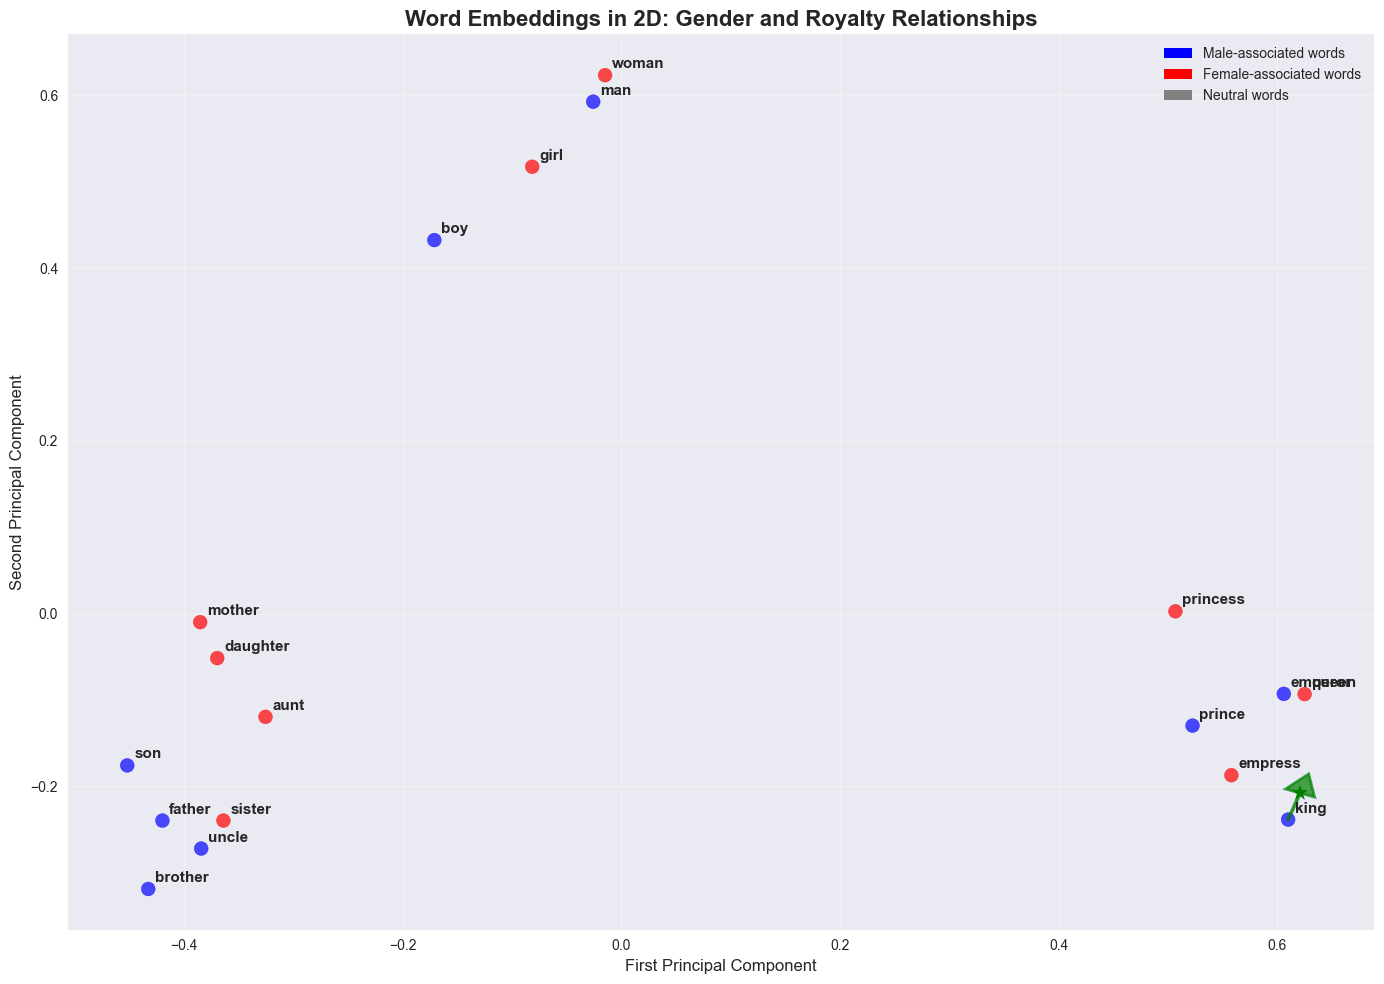


📊 Notice how male and female words cluster in different regions!
This shows that the model learned to encode gender relationships in the vector space.


In [42]:
# Words we want to visualize
words_to_plot = [
    "king", "queen", "man", "woman", "prince", "princess",
    "emperor", "empress", "boy", "girl", "father", "mother",
    "son", "daughter", "uncle", "aunt", "brother", "sister"
]

# Get embeddings for all words
embeddings = []
valid_words = []

for word in words_to_plot:
    try:
        embedding = model.embeddings([word])[0]
        embeddings.append(embedding)
        valid_words.append(word)
    except:
        print(f"⚠️  Could not find embedding for '{word}'")

embeddings = np.array(embeddings)
print(f"Successfully loaded {len(valid_words)} word embeddings")

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

print(f"\nPCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total variance captured: {sum(pca.explained_variance_ratio_):.1%}")

# Create visualization
plt.figure(figsize=(14, 10))

# Color-code by gender associations
male_words = ["king", "man", "prince", "emperor", "boy", "father", "son", "uncle", "brother"]
female_words = ["queen", "woman", "princess", "empress", "girl", "mother", "daughter", "aunt", "sister"]

colors = []
for word in valid_words:
    if word in male_words:
        colors.append('blue')
    elif word in female_words:
        colors.append('red')
    else:
        colors.append('gray')

# Create scatter plot
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
           c=colors, alpha=0.7, s=100)

# Add word labels
for i, word in enumerate(valid_words):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=11, fontweight='bold')

# Add the analogy vectors
# Add the analogy vectors
if "king" in valid_words and "man" in valid_words and "woman" in valid_words:
    king_idx = valid_words.index("king")
    man_idx = valid_words.index("man")
    woman_idx = valid_words.index("woman")
    
    # Calculate the result in 2D space
    result_2d = embeddings_2d[king_idx] - embeddings_2d[man_idx] + embeddings_2d[woman_idx]
    
    # Calculate arrow properties based on the actual coordinate range
    x_range = embeddings_2d[:, 0].max() - embeddings_2d[:, 0].min()
    y_range = embeddings_2d[:, 1].max() - embeddings_2d[:, 1].min()
    
    # Make arrow head proportional to the plot size (typically 2-5% of range)
    head_width = min(x_range, y_range) * 0.03
    head_length = min(x_range, y_range) * 0.025
    
    # Draw arrow to show the vector arithmetic
    plt.arrow(embeddings_2d[king_idx, 0], embeddings_2d[king_idx, 1],
              result_2d[0] - embeddings_2d[king_idx, 0],
              result_2d[1] - embeddings_2d[king_idx, 1],
              head_width=head_width, head_length=head_length, 
              fc='green', ec='green', alpha=0.7,
              linewidth=2, label='king - man + woman')
    
    plt.plot(result_2d[0], result_2d[1], 'g*', markersize=12, label='Calculated result')

plt.title('Word Embeddings in 2D: Gender and Royalty Relationships', fontsize=16, fontweight='bold')
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Add color legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', label='Male-associated words'),
                  Patch(facecolor='red', label='Female-associated words'),
                  Patch(facecolor='gray', label='Neutral words')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\n📊 Notice how male and female words cluster in different regions!")
print("This shows that the model learned to encode gender relationships in the vector space.")

## Part 6: Library Science Application - The Franz Schubert Problem

Now let's apply what we've learned to a real library science challenge. We need to distinguish between two people with the same name using the semantic context of their associated works.

This demonstrates how embeddings can solve entity resolution problems that traditional string matching cannot.

In [ ]:
# Create composite descriptions based on Yale Library catalog records
composer_record = """
Franz Schubert 1797-1828 composer symphony lieder piano sonata music classical 
Austrian Vienna romantic period string quartet mass song cycle musical composition
"""

artist_record = """
Franz Schubert 1805-1893 artist archaeology photography illustration German 
Dessau visual art archaeological documentation scientific illustration drawing
"""

# Function to calculate embedding for a text by averaging word vectors
def text_to_embedding(model, text):
    """
    Convert text to embedding by averaging word vectors.
    This is a simple but effective approach for short texts.
    """
    words = text.lower().split()
    embeddings = []
    
    for word in words:
        try:
            embedding = model.embeddings([word])[0]
            embeddings.append(embedding)
        except:
            # Skip words not in vocabulary
            continue
    
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(300)  # Return zero vector if no words found

# Calculate embeddings for both records
composer_embedding = text_to_embedding(model, composer_record)
artist_embedding = text_to_embedding(model, artist_record)

print("✅ Calculated embeddings for both Franz Schubert records")
print(f"Composer embedding shape: {composer_embedding.shape}")
print(f"Artist embedding shape: {artist_embedding.shape}")

# Calculate similarity between the two records
similarity = cosine_similarity(
    composer_embedding.reshape(1, -1),
    artist_embedding.reshape(1, -1)
)[0][0]

print(f"\n🎯 Similarity between the two Franz Schubert records: {similarity:.3f}")

if similarity < 0.5:
    print("✅ Low similarity suggests these are different people despite the same name!")
else:
    print("⚠️  High similarity - the model might see these as the same person.")

# Test with some domain-specific words to see the semantic differences
music_words = ["symphony", "piano", "classical", "composition"]
archaeology_words = ["archaeology", "illustration", "documentation", "scientific"]

print("\n🎼 Testing similarity to music domain:")
for word in music_words:
    try:
        word_embedding = model.embeddings([word])[0]
        composer_sim = cosine_similarity(composer_embedding.reshape(1, -1), 
                                       word_embedding.reshape(1, -1))[0][0]
        artist_sim = cosine_similarity(artist_embedding.reshape(1, -1), 
                                     word_embedding.reshape(1, -1))[0][0]
        print(f"  {word}: Composer={composer_sim:.3f}, Artist={artist_sim:.3f}")
    except:
        print(f"  {word}: Not found in vocabulary")

print("\n🏛️ Testing similarity to archaeology domain:")
for word in archaeology_words:
    try:
        word_embedding = model.embeddings([word])[0]
        composer_sim = cosine_similarity(composer_embedding.reshape(1, -1), 
                                       word_embedding.reshape(1, -1))[0][0]
        artist_sim = cosine_similarity(artist_embedding.reshape(1, -1), 
                                     word_embedding.reshape(1, -1))[0][0]
        print(f"  {word}: Composer={composer_sim:.3f}, Artist={artist_sim:.3f}")
    except:
        print(f"  {word}: Not found in vocabulary")

## Part 7: Exploring Semantic Neighborhoods

Let's explore how different domains cluster in the embedding space. This will help us understand why embeddings are so powerful for distinguishing between different fields of knowledge.

✅ Music: Found 7/7 words
✅ Archaeology: Found 6/6 words
✅ Photography: Found 6/6 words
✅ Literature: Found 6/6 words

📏 Inter-domain similarities (higher = more similar):
  Music ↔ Archaeology: 0.316
  Music ↔ Photography: 0.217
  Music ↔ Literature: 0.386
  Archaeology ↔ Photography: 0.194
  Archaeology ↔ Literature: 0.326
  Photography ↔ Literature: 0.220


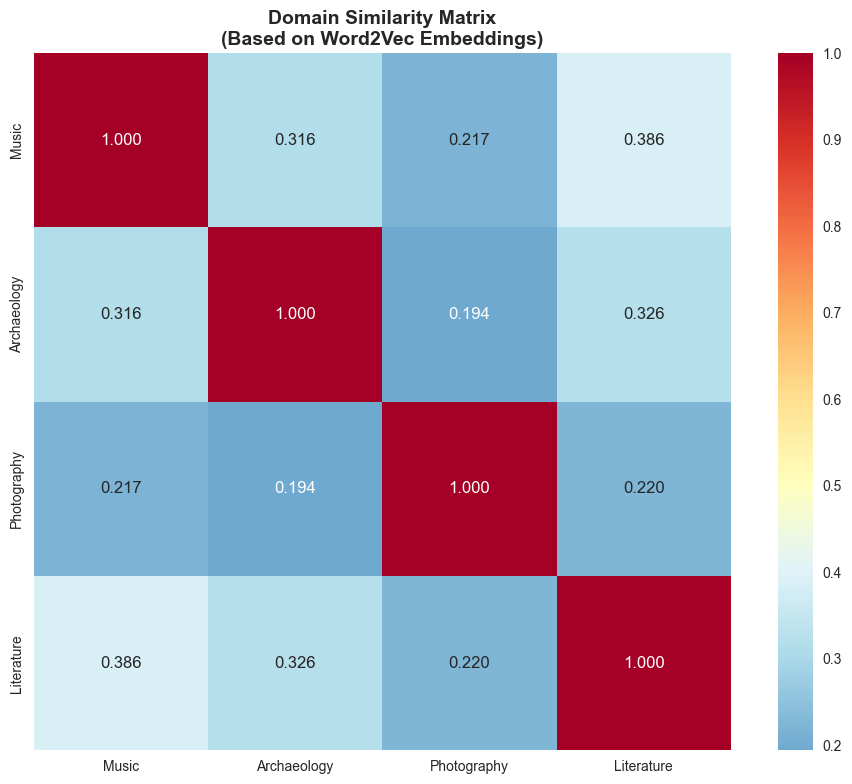


🎯 Franz Schubert Records vs. Domain Centroids:
  Music        | Composer: 0.844 | Artist: 0.382 | → Composer (+0.463)
  Archaeology  | Composer: 0.315 | Artist: 0.468 | → Artist (+0.153)
  Photography  | Composer: 0.234 | Artist: 0.482 | → Artist (+0.248)
  Literature   | Composer: 0.462 | Artist: 0.428 | → Composer (+0.034)


In [43]:
# Define domain-specific word sets
domains = {
    'Music': ['symphony', 'piano', 'classical', 'composition', 'melody', 'harmony', 'orchestra'],
    'Archaeology': ['excavation', 'artifact', 'ancient', 'civilization', 'pottery', 'ruins'],
    'Photography': ['camera', 'lens', 'exposure', 'photograph', 'image', 'visual'],
    'Literature': ['novel', 'poetry', 'narrative', 'author', 'manuscript', 'writing']
}

# Calculate domain centroids (average embedding for each domain)
domain_centroids = {}
domain_words_found = {}

for domain, words in domains.items():
    embeddings = []
    found_words = []
    
    for word in words:
        try:
            embedding = model.embeddings([word])[0]
            embeddings.append(embedding)
            found_words.append(word)
        except:
            continue
    
    if embeddings:
        domain_centroids[domain] = np.mean(embeddings, axis=0)
        domain_words_found[domain] = found_words
        print(f"✅ {domain}: Found {len(found_words)}/{len(words)} words")
    else:
        print(f"❌ {domain}: No words found in vocabulary")

# Calculate distances between domain centroids
print("\n📏 Inter-domain similarities (higher = more similar):")
domain_names = list(domain_centroids.keys())
similarity_matrix = np.zeros((len(domain_names), len(domain_names)))

for i, domain1 in enumerate(domain_names):
    for j, domain2 in enumerate(domain_names):
        if i != j:
            similarity = cosine_similarity(
                domain_centroids[domain1].reshape(1, -1),
                domain_centroids[domain2].reshape(1, -1)
            )[0][0]
            similarity_matrix[i, j] = similarity
            if i < j:  # Only print upper triangle to avoid duplicates
                print(f"  {domain1} ↔ {domain2}: {similarity:.3f}")
        else:
            similarity_matrix[i, j] = 1.0

# Visualize domain similarities as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, 
            xticklabels=domain_names, 
            yticklabels=domain_names,
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            center=0.5,
            square=True)
plt.title('Domain Similarity Matrix\n(Based on Word2Vec Embeddings)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Test our Franz Schubert records against domain centroids
print("\n🎯 Franz Schubert Records vs. Domain Centroids:")
for domain, centroid in domain_centroids.items():
    composer_sim = cosine_similarity(composer_embedding.reshape(1, -1), 
                                   centroid.reshape(1, -1))[0][0]
    artist_sim = cosine_similarity(artist_embedding.reshape(1, -1), 
                                 centroid.reshape(1, -1))[0][0]
    
    better_match = "Composer" if composer_sim > artist_sim else "Artist"
    difference = abs(composer_sim - artist_sim)
    
    print(f"  {domain:12} | Composer: {composer_sim:.3f} | Artist: {artist_sim:.3f} | → {better_match} (+{difference:.3f})")

## Part 8: Understanding Tokenization

Now that we've seen the power of word embeddings, let's step back and understand how text becomes tokens that can be processed by embedding models.

Tokenization is the process of breaking text into discrete units (tokens) that a model can understand. Different tokenization strategies can significantly impact model performance.

In [44]:
# Simple whitespace tokenization
sample_text = "Franz Schubert (1797-1828) composed the 'Unfinished Symphony' in B minor."

print("📝 Sample text:")
print(f'"{sample_text}"')

# Method 1: Simple whitespace splitting
whitespace_tokens = sample_text.split()
print(f"\n🔤 Whitespace tokenization ({len(whitespace_tokens)} tokens):")
for i, token in enumerate(whitespace_tokens):
    print(f"  {i+1:2d}. '{token}'")

# Method 2: More sophisticated tokenization
import re

def better_tokenize(text):
    """A slightly more sophisticated tokenizer that handles punctuation."""
    # Split on whitespace and punctuation, but keep punctuation as separate tokens
    tokens = re.findall(r"\w+|[^\w\s]", text)
    return tokens

better_tokens = better_tokenize(sample_text)
print(f"\n🎯 Better tokenization ({len(better_tokens)} tokens):")
for i, token in enumerate(better_tokens):
    print(f"  {i+1:2d}. '{token}'")

# Demonstrate the impact on our Franz Schubert records
print("\n" + "="*60)
print("🎼 Tokenizing Franz Schubert Composer Record:")
print("="*60)

composer_tokens = better_tokenize(composer_record.strip())
print(f"Total tokens: {len(composer_tokens)}")
print("Tokens:")
for i, token in enumerate(composer_tokens[:20]):  # Show first 20 tokens
    print(f"  {i+1:2d}. '{token}'")
if len(composer_tokens) > 20:
    print(f"  ... and {len(composer_tokens) - 20} more tokens")

print("\n" + "="*60)
print("🏛️ Tokenizing Franz Schubert Artist Record:")
print("="*60)

artist_tokens = better_tokenize(artist_record.strip())
print(f"Total tokens: {len(artist_tokens)}")
print("Tokens:")
for i, token in enumerate(artist_tokens[:20]):  # Show first 20 tokens
    print(f"  {i+1:2d}. '{token}'")
if len(artist_tokens) > 20:
    print(f"  ... and {len(artist_tokens) - 20} more tokens")

📝 Sample text:
"Franz Schubert (1797-1828) composed the 'Unfinished Symphony' in B minor."

🔤 Whitespace tokenization (10 tokens):
   1. 'Franz'
   2. 'Schubert'
   3. '(1797-1828)'
   4. 'composed'
   5. 'the'
   6. ''Unfinished'
   7. 'Symphony''
   8. 'in'
   9. 'B'
  10. 'minor.'

🎯 Better tokenization (17 tokens):
   1. 'Franz'
   2. 'Schubert'
   3. '('
   4. '1797'
   5. '-'
   6. '1828'
   7. ')'
   8. 'composed'
   9. 'the'
  10. '''
  11. 'Unfinished'
  12. 'Symphony'
  13. '''
  14. 'in'
  15. 'B'
  16. 'minor'
  17. '.'

🎼 Tokenizing Franz Schubert Composer Record:
Total tokens: 23
Tokens:
   1. 'Franz'
   2. 'Schubert'
   3. '1797'
   4. '-'
   5. '1828'
   6. 'composer'
   7. 'symphony'
   8. 'lieder'
   9. 'piano'
  10. 'sonata'
  11. 'music'
  12. 'classical'
  13. 'Austrian'
  14. 'Vienna'
  15. 'romantic'
  16. 'period'
  17. 'string'
  18. 'quartet'
  19. 'mass'
  20. 'song'
  ... and 3 more tokens

🏛️ Tokenizing Franz Schubert Artist Record:
Total tokens: 18
Tokens:

## Part 9: Token Coverage and Vocabulary Issues

One challenge with pre-trained embeddings is vocabulary coverage. Not all tokens in your text may have corresponding embeddings in the model. Let's examine this issue with our library records.

In [46]:
def analyze_token_coverage(model, text, description):
    """Analyze which tokens have embeddings in the model."""
    tokens = better_tokenize(text.strip())
    
    found_tokens = []
    missing_tokens = []
    
    for token in tokens:
        # Skip very short tokens and pure numbers
        if len(token) < 2 or token.isdigit():
            continue
            
        try:
            # Try to get embedding for this token
            embedding = model.embeddings([token.lower()])
            found_tokens.append(token.lower())
        except:
            missing_tokens.append(token.lower())
    
    coverage = len(found_tokens) / (len(found_tokens) + len(missing_tokens)) if (found_tokens or missing_tokens) else 0
    
    print(f"\n📊 Token Coverage Analysis for {description}:")
    print(f"  Total meaningful tokens: {len(found_tokens) + len(missing_tokens)}")
    print(f"  Tokens with embeddings: {len(found_tokens)}")
    print(f"  Tokens missing: {len(missing_tokens)}")
    print(f"  Coverage: {coverage:.1%}")
    
    if missing_tokens:
        print(f"  Missing tokens: {', '.join(missing_tokens[:10])}")
        if len(missing_tokens) > 10:
            print(f"    ... and {len(missing_tokens) - 10} more")
    
    return found_tokens, missing_tokens, coverage

# Analyze both Franz Schubert records
composer_found, composer_missing, composer_coverage = analyze_token_coverage(
    model, composer_record, "Composer Record"
)

artist_found, artist_missing, artist_coverage = analyze_token_coverage(
    model, artist_record, "Artist Record"
)

# Compare the domain-specific vocabulary
print("\n🎯 Domain-Specific Token Analysis:")

# Find tokens unique to each record
composer_unique = set(composer_found) - set(artist_found)
artist_unique = set(artist_found) - set(composer_found)
shared_tokens = set(composer_found) & set(artist_found)

print(f"\n🎼 Tokens unique to composer: {len(composer_unique)}")
if composer_unique:
    print(f"  {', '.join(list(composer_unique)[:10])}")

print(f"\n🏛️ Tokens unique to artist: {len(artist_unique)}")
if artist_unique:
    print(f"  {', '.join(list(artist_unique)[:10])}")

print(f"\n🤝 Shared tokens: {len(shared_tokens)}")
if shared_tokens:
    print(f"  {', '.join(list(shared_tokens)[:10])}")

# Calculate semantic distinctiveness
distinctiveness = (len(composer_unique) + len(artist_unique)) / (len(composer_found) + len(artist_found))
print(f"\n📏 Semantic distinctiveness: {distinctiveness:.1%}")
print("   (Higher values indicate more distinct vocabularies)")


📊 Token Coverage Analysis for Composer Record:
  Total meaningful tokens: 20
  Tokens with embeddings: 20
  Tokens missing: 0
  Coverage: 100.0%

📊 Token Coverage Analysis for Artist Record:
  Total meaningful tokens: 15
  Tokens with embeddings: 15
  Tokens missing: 0
  Coverage: 100.0%

🎯 Domain-Specific Token Analysis:

🎼 Tokens unique to composer: 18
  period, piano, quartet, composer, sonata, musical, vienna, mass, composition, string

🏛️ Tokens unique to artist: 12
  documentation, german, dessau, art, visual, archaeology, drawing, illustration, archaeological, photography

🤝 Shared tokens: 2
  franz, schubert

📏 Semantic distinctiveness: 85.7%
   (Higher values indicate more distinct vocabularies)


## Part 10: Modern Tokenization Approaches

While Word2Vec uses simple word-level tokenization, modern models often use subword tokenization techniques like Byte Pair Encoding (BPE) or SentencePiece. Let's explore why this matters.

In [45]:
# Demonstrate the out-of-vocabulary problem
challenging_words = [
    "archaeologist",  # Compound word
    "Schubert's",     # Possessive
    "nineteenth-century",  # Hyphenated
    "Unfinished",     # May or may not be in vocabulary
    "lieder",         # German musical term
    "Singspiel",      # Another German term
    "counterpoint",   # Technical musical term
]

print("🔍 Testing Vocabulary Coverage for Challenging Words:")
print("=" * 55)

for word in challenging_words:
    try:
        embedding = model.embeddings([word.lower()])
        print(f"  ✅ '{word}' → Found in vocabulary")
    except:
        print(f"  ❌ '{word}' → Not found in vocabulary")
        
        # Show how subword tokenization might help
        if "-" in word:
            parts = word.split("-")
            print(f"     Could split into: {parts}")
        elif "'" in word:
            base_word = word.replace("'s", "")
            print(f"     Could use base word: '{base_word}'")

print("\n💡 This demonstrates why modern models use subword tokenization!")
print("   Subword methods can handle:")
print("   • Out-of-vocabulary words by breaking them into known pieces")
print("   • Morphological variations (plurals, possessives, etc.)")
print("   • Domain-specific terminology")
print("   • Multiple languages in the same model")

🔍 Testing Vocabulary Coverage for Challenging Words:
  ✅ 'archaeologist' → Found in vocabulary
  ✅ 'Schubert's' → Found in vocabulary
  ✅ 'nineteenth-century' → Found in vocabulary
  ✅ 'Unfinished' → Found in vocabulary
  ✅ 'lieder' → Found in vocabulary
  ✅ 'Singspiel' → Found in vocabulary
  ✅ 'counterpoint' → Found in vocabulary

💡 This demonstrates why modern models use subword tokenization!
   Subword methods can handle:
   • Out-of-vocabulary words by breaking them into known pieces
   • Morphological variations (plurals, possessives, etc.)
   • Domain-specific terminology
   • Multiple languages in the same model


In [47]:
# Modern Tokenization: From Words to Subwords
# Understanding why and how tokenization evolved beyond simple word splitting

print("🔬 EVOLUTION OF TOKENIZATION METHODS")
print("=" * 50)

print("So far, we've seen simple word-level tokenization that splits on whitespace and punctuation.")
print("But modern AI systems use much more sophisticated approaches. Let's explore why this")
print("evolution happened and what problems it solved.")

print("\n🤔 Problems with Simple Word-Level Tokenization:")
print("\nRemember our earlier tokenization challenges? Let's revisit them with fresh perspective:")

# Recall our challenging examples from earlier
challenging_examples = [
    "Schubert's Unfinished Symphony",
    "nineteenth-century manuscripts", 
    "archaeological photography",
    "Singspiel and lieder compositions",
    "digitization workflows"
]

print("\n📝 Testing vocabulary coverage with challenging library terms:")
for example in challenging_examples:
    tokens = example.split()
    print(f"\nText: '{example}'")
    print(f"Simple tokens: {tokens}")
    
    # Count how many might be out-of-vocabulary
    likely_oov = []
    for token in tokens:
        # Check for indicators that suggest OOV issues
        if "'" in token or "-" in token or token[0].isupper() or len(token) > 12:
            likely_oov.append(token)
    
    if likely_oov:
        print(f"Potentially problematic tokens: {likely_oov}")
        print("Issues: possessives, hyphenation, proper nouns, specialized terminology")
    else:
        print("All tokens likely in standard vocabulary")

print("\n💡 Why These Problems Matter for Libraries:")
print("Academic and cultural heritage collections contain exactly the kinds of texts that")
print("challenge simple tokenization: multilingual content, historical spelling variations,")
print("specialized terminology, and domain-specific compound words. We need tokenization")
print("methods that can handle this linguistic diversity gracefully.")

print("\n🎯 Enter Subword Tokenization:")
print("Instead of treating words as indivisible units, modern approaches break words into")
print("smaller meaningful pieces. This allows models to handle unknown words by combining")
print("known subword pieces, dramatically improving vocabulary coverage.")

print("\nThink of it like this: if you don't know the word 'archaeological', but you")
print("understand 'archae' + 'olog' + 'ical', you can still make sense of the concept.")
print("Subword tokenization teaches models to do exactly this kind of compositional reasoning.")

🔬 EVOLUTION OF TOKENIZATION METHODS
So far, we've seen simple word-level tokenization that splits on whitespace and punctuation.
But modern AI systems use much more sophisticated approaches. Let's explore why this
evolution happened and what problems it solved.

🤔 Problems with Simple Word-Level Tokenization:

Remember our earlier tokenization challenges? Let's revisit them with fresh perspective:

📝 Testing vocabulary coverage with challenging library terms:

Text: 'Schubert's Unfinished Symphony'
Simple tokens: ["Schubert's", 'Unfinished', 'Symphony']
Potentially problematic tokens: ["Schubert's", 'Unfinished', 'Symphony']
Issues: possessives, hyphenation, proper nouns, specialized terminology

Text: 'nineteenth-century manuscripts'
Simple tokens: ['nineteenth-century', 'manuscripts']
Potentially problematic tokens: ['nineteenth-century']
Issues: possessives, hyphenation, proper nouns, specialized terminology

Text: 'archaeological photography'
Simple tokens: ['archaeological', 'phot

In [48]:
# Install and demonstrate tiktoken for modern subword tokenization
!pip install tiktoken

import tiktoken

print("🤖 TIKTOKEN: GPT-4'S TOKENIZATION APPROACH")
print("=" * 50)

print("TikToken implements the tokenization used by OpenAI's GPT models. This approach")
print("uses Byte Pair Encoding (BPE), which learns to merge frequently occurring character")
print("pairs into larger subword units. Let's see how it handles our challenging examples.")

# Load the GPT-4 tokenizer
# This is the same tokenizer used by the models that power ChatGPT and GPT-4
try:
    # Get the encoding used by GPT-4
    gpt4_encoding = tiktoken.encoding_for_model("gpt-4")
    print("✅ Loaded GPT-4 tokenizer (cl100k_base encoding)")
    
    # Alternative if the above doesn't work
    # gpt4_encoding = tiktoken.get_encoding("cl100k_base")
    
except Exception as e:
    print(f"⚠️  Could not load GPT-4 tokenizer: {e}")
    print("Falling back to a different encoding...")
    gpt4_encoding = tiktoken.get_encoding("cl100k_base")

def analyze_tokenization(text, encoding, description=""):
    """
    Analyze how a modern tokenizer handles text, with educational commentary.
    
    This function demonstrates the power of subword tokenization by showing
    exactly how text gets broken down into tokens that the model can process.
    """
    print(f"\n🔍 Analyzing: '{text}' {description}")
    
    # Encode text to tokens (numbers that represent subword pieces)
    token_ids = encoding.encode(text)
    
    # Decode tokens back to text pieces to see the subword boundaries  
    tokens = [encoding.decode([token_id]) for token_id in token_ids]
    
    print(f"📊 Token count: {len(tokens)} (compare to {len(text.split())} words)")
    print(f"🔢 Token IDs: {token_ids[:10]}{'...' if len(token_ids) > 10 else ''}")
    print(f"🧩 Subword tokens:")
    
    for i, token in enumerate(tokens):
        # Show token with special characters made visible
        display_token = repr(token)  # This shows spaces as \\ and special chars clearly
        print(f"  {i+1:2d}. {display_token}")
        
        # Provide educational commentary on interesting tokenization decisions
        if token.startswith(' '):
            print(f"      ↳ Starts with space - this is the beginning of a new word")
        elif token.startswith('##') or not token.startswith(' ') and i > 0:
            print(f"      ↳ Continues previous token - part of compound/complex word")
        elif len(token) == 1 and not token.isalnum():
            print(f"      ↳ Single punctuation character")
        elif any(char.isdigit() for char in token):
            print(f"      ↳ Contains numbers - often tokenized specially")
    
    return token_ids, tokens

# Test the tokenizer on our challenging examples
print("\n📚 Testing Modern Tokenization on Library Science Examples:")

library_examples = [
    ("Schubert's Unfinished Symphony", "- possessive and proper nouns"),
    ("nineteenth-century manuscripts", "- hyphenated compound adjective"), 
    ("Archäologie und Photographie", "- German text with special characters"),
    ("digitization workflows", "- domain-specific terminology"),
    ("Franz August Schubert (1806-1893)", "- names with dates and punctuation"),
    ("lieder and Singspiel compositions", "- German musical terms")
]

for text, description in library_examples:
    analyze_tokenization(text, gpt4_encoding, description)

print(f"\n🎓 Key Insights About Modern Tokenization:")
print("Notice how the tokenizer handles challenges that simple word splitting cannot:")
print("• Possessives like \"Schubert's\" are split intelligently")
print("• Hyphenated words are broken at meaningful boundaries") 
print("• Foreign words are decomposed into recognizable parts")
print("• Punctuation is separated but context is preserved")
print("• Domain terminology is broken into learnable subword pieces")

print(f"\n💰 Practical Implications for Library Systems:")
print("This sophisticated tokenization explains why modern language models work so well")
print("with library catalogs, even when they encounter rare terminology, historical")
print("spelling variants, or multilingual content. The subword approach provides robust")
print("coverage while maintaining semantic coherence.")


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
🤖 TIKTOKEN: GPT-4'S TOKENIZATION APPROACH
TikToken implements the tokenization used by OpenAI's GPT models. This approach
uses Byte Pair Encoding (BPE), which learns to merge frequently occurring character
pairs into larger subword units. Let's see how it handles our challenging examples.
✅ Loaded GPT-4 tokenizer (cl100k_base encoding)

📚 Testing Modern Tokenization on Library Science Examples:

🔍 Analyzing: 'Schubert's Unfinished Symphony' - possessive and proper nouns
📊 Token count: 7 (compare to 3 words)
🔢 Token IDs: [31224, 392, 531, 596, 1252, 12402, 63306]
🧩 Subword tokens:
   1. 'Sch'
   2. 'ub'
      ↳ Continues previous token - part of compound/complex word
   3. 'ert'
      ↳ Continues previous token - part of compound/complex word
   4. "'s"
      ↳ Continues previous token - part of compound/complex word
   5. ' Un'
      ↳ Starts with space - this is th

## Part 11: Practical Implications for Library Applications

Let's summarize what we've learned and discuss how these concepts apply to real library metadata challenges.

In [ ]:
# Create a summary visualization of our findings
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Domain similarities
if len(domain_centroids) >= 2:
    domain_pairs = []
    similarities = []
    
    for i, domain1 in enumerate(domain_names):
        for j, domain2 in enumerate(domain_names):
            if i < j:
                domain_pairs.append(f"{domain1}\nvs\n{domain2}")
                similarities.append(similarity_matrix[i, j])
    
    ax1.bar(range(len(similarities)), similarities, color='skyblue', alpha=0.7)
    ax1.set_xticks(range(len(similarities)))
    ax1.set_xticklabels(domain_pairs, rotation=45, ha='right')
    ax1.set_ylabel('Cosine Similarity')
    ax1.set_title('Inter-Domain Similarities', fontweight='bold')
    ax1.grid(True, alpha=0.3)

# 2. Token coverage comparison
coverage_data = ['Composer', 'Artist']
coverage_values = [composer_coverage, artist_coverage]
bars = ax2.bar(coverage_data, coverage_values, color=['blue', 'red'], alpha=0.7)
ax2.set_ylabel('Token Coverage')
ax2.set_title('Vocabulary Coverage by Record Type', fontweight='bold')
ax2.set_ylim(0, 1)
for bar, value in zip(bars, coverage_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.1%}', ha='center', va='bottom', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Vocabulary overlap analysis
if composer_found and artist_found:
    overlap_data = ['Composer Only', 'Shared', 'Artist Only']
    overlap_values = [len(composer_unique), len(shared_tokens), len(artist_unique)]
    colors = ['blue', 'purple', 'red']
    
    wedges, texts, autotexts = ax3.pie(overlap_values, labels=overlap_data, 
                                      colors=colors, autopct='%1.1f%%', 
                                      startangle=90, alpha=0.7)
    ax3.set_title('Token Overlap Between Records', fontweight='bold')

# 4. Franz Schubert similarity to domains
if domain_centroids:
    x = np.arange(len(domain_names))
    width = 0.35
    
    composer_sims = []
    artist_sims = []
    
    for domain in domain_names:
        if domain in domain_centroids:
            composer_sim = cosine_similarity(composer_embedding.reshape(1, -1), 
                                           domain_centroids[domain].reshape(1, -1))[0][0]
            artist_sim = cosine_similarity(artist_embedding.reshape(1, -1), 
                                         domain_centroids[domain].reshape(1, -1))[0][0]
            composer_sims.append(composer_sim)
            artist_sims.append(artist_sim)
    
    bars1 = ax4.bar(x - width/2, composer_sims, width, label='Composer Record', 
                    color='blue', alpha=0.7)
    bars2 = ax4.bar(x + width/2, artist_sims, width, label='Artist Record', 
                    color='red', alpha=0.7)
    
    ax4.set_xlabel('Domain')
    ax4.set_ylabel('Similarity to Domain Centroid')
    ax4.set_title('Franz Schubert Records vs. Domain Centroids', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(domain_names, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Key Takeaways for Library Applications:")
print("=" * 50)
print("✅ Embeddings can distinguish between people with identical names")
print("✅ Domain-specific vocabulary creates semantic fingerprints")
print("✅ Vector arithmetic captures meaningful relationships")
print("✅ Visualization helps understand high-dimensional relationships")
print("⚠️  Vocabulary coverage affects embedding quality")
print("⚠️  Tokenization strategy impacts model performance")
print("\n💡 Next Steps: Modern sentence embeddings and vector databases!")

## Summary and Reflection

Congratulations! You've now experienced the fundamental concepts behind text embeddings:

### What We Learned
1. **Vector Semantics**: Words are represented as points in high-dimensional space where similar words cluster together
2. **Algebraic Relationships**: Vector arithmetic can capture semantic relationships (king - man + woman ≈ queen)
3. **Entity Resolution**: Embeddings can distinguish between people with identical names using contextual information
4. **Domain Clustering**: Related concepts naturally group together in embedding space
5. **Tokenization Impact**: How text is split into tokens affects what the model can understand

### Real-World Applications
- **Library Catalogs**: Disambiguating authors, subjects, and works
- **Metadata Quality**: Identifying inconsistencies and errors in catalog records
- **Discovery Systems**: Improving search through semantic understanding
- **Collection Development**: Finding related materials across different classification systems

### Limitations We Discovered
- Vocabulary coverage issues with specialized terms
- Language and cultural biases in training data
- Static representations (Word2Vec doesn't handle context)
- Dimensionality reduction loses information

### Looking Forward
Modern embedding models like OpenAI's text-embedding-3-small address many of these limitations through:
- Contextual embeddings that change based on surrounding text
- Subword tokenization for better vocabulary coverage
- Training on more diverse, recent data
- Integration with vector databases for efficient similarity search

In our next notebook, we'll explore how to use these modern embeddings with Weaviate vector database for large-scale semantic search applications!